In [4]:
import numpy as np
import pandas as pd
from textblob import TextBlob
from bs4 import BeautifulSoup
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import *
import re
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [56]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
pip install wordcloud 


Note: you may need to restart the kernel to use updated packages.


### Data loading function

In [5]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


In [6]:
df = getDF('reviews_Home_and_Kitchen_5.json.gz')

### Snapshot of Data

In [5]:
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


### Shape of the data

In [6]:
df.shape

(551682, 9)

### Missing Values

In [7]:
df.isna().sum()

reviewerID           0
asin                 0
reviewerName      4953
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

There are no any missing values in any variable except that in reviewerName variable. We do not need reviewerName variable in our analysis. So, We will continue using all data for our further analysis.

Trying to understand the customer sentiment in multiple directions. I would like to start with Logistic Regression and will see how it works.

Feature extraction/Feature engineering. In this process let's see how we can use 'helpful' variable to understand customer preferences.

In [8]:
df.groupby('overall').count()

,reviewerID,asin,reviewerName,helpful,reviewText,summary,unixReviewTime,reviewTime
overall,,,,,,,,
1.0,27106,27106,26852,27106,27106,27106,27106,27106
2.0,24313,24313,24079,24313,24313,24313,24313,24313
3.0,45059,45059,44607,45059,45059,45059,45059,45059
4.0,105508,105508,104586,105508,105508,105508,105508,105508
5.0,349696,349696,346605,349696,349696,349696,349696,349696


We can see that there are more positively rated reviews, ie. reviews where customer rated the product/servise as 4 or 5
This indicates 2 things 
* Costomers are mostly happy/positive 
*  The distribution is skewed

Lets do some data preprocessing first

### Data preprocessing

#### "helpful" Column

In [7]:
# Make new two columns out of 'helpful' column
df[['helpfulfirstelement', 'helpfulsecondelement']] = pd.DataFrame(df.helpful.values.tolist(), index = df.index)
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpfulfirstelement,helpfulsecondelement
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013",0,0
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014",0,0
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013",26,27
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011",14,18
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014",0,0


### Remove any duplicates
check for any duplicate rows by performing a group by and sort function of dataframe

In [8]:
#unique reviewers
print(len(df['reviewerID'].unique()))

#unique asin
#Note: Amazon Standard Identification Number: Each product sold on Amazon.com is given a unique ASIN
print(len(df['asin'].unique()))

#unique reviws time
print(len(df['unixReviewTime'].unique()))

66519
28237
4805


We see that total of 66,519 customers gave reviews for 28,237 items and 4805 unique timestamps
Group by asin number to check the number of reviewrs for each product(total 28,237 products)

In [9]:
#group by analysis
gdf=df.groupby('asin').agg({'reviewerID':['count']}).sort_values(by=['asin'])
gdf

,reviewerID
,count
asin,
0615391206,11
0689027818,5
0912696591,93
1223070743,8
1567120709,16
1891747401,15
1983475912,6
2042037265,6


In [14]:
#gdf.loc[gdf['asin']=='B00004S7YF']

In [10]:
#sort analysis
sdf=df.sort_values(by=['reviewerID','asin','unixReviewTime'])

In [11]:
sdf.loc[sdf['asin']=='B00004S7YF'].sort_values(by=['unixReviewTime'])


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpfulfirstelement,helpfulsecondelement
11656,A3ICQSEUGFRAKM,B00004S7YF,Rebecca A. Sexton,"[9, 13]","This set has 29 tips, a flower nail and one co...",5.0,Wilton Supreme Cake Decorating Set,1152662400,"07 12, 2006",9,13
11661,A3KY2CMX2SZQ94,B00004S7YF,T. Horak,"[5, 6]",This is a good starter set if you are just get...,4.0,Nice starter set,1174521600,"03 22, 2007",5,6
11652,A38F2FD9K0C78V,B00004S7YF,Nirmala Mohabir,"[19, 21]",I love this set- it's perfect for beginners wh...,5.0,Great deal on this purchase,1203897600,"02 25, 2008",19,21
11646,AJB4VS9J7HKID,B00004S7YF,Donna Snyder,"[2, 3]",I needed a new kit that had all the parts! Thi...,5.0,Wilton cake decorating kit,1230681600,"12 31, 2008",2,3
11657,ANBIG4SVNUAZC,B00004S7YF,R. Murphy,"[11, 13]",I purchased this set since it seemed the best ...,4.0,"Lots of tips, very pale colors",1290297600,"11 21, 2010",11,13
11651,A2ZM09SXQD77H0,B00004S7YF,N. Black,"[2, 2]","I bought this, practiced with regular supermar...",5.0,Easy peasy.,1297987200,"02 18, 2011",2,2
11653,AAY3WZSAPD0VV,B00004S7YF,Pinky,"[0, 0]",Ive been decorating cakes for fun for a few ye...,5.0,Inexperienced users will have a lot of fun,1325030400,"12 28, 2011",0,0
11641,A22MKMQ1AYXRGT,B00004S7YF,Avid reader,"[1, 1]",This is really a good deal. This kit includes...,5.0,A great deal!,1331078400,"03 7, 2012",1,1
11645,A25C2M3QF9G7OQ,B00004S7YF,Comdet,"[74, 75]",I wanted to get a cake decorating kit for my n...,5.0,"Excellent starter set, better value than the W...",1354320000,"12 1, 2012",74,75
11650,AEGB49B843XLF,B00004S7YF,"Michelle - Seacoast NH ""Michelle - Seacoast NH""","[0, 0]",Bought as a gift. It looks quite nice for the ...,4.0,Good beginner set,1355961600,"12 20, 2012",0,0


### Remove duplicate rows
Rows with same reviewer, asin adn unixtime can be considered as duplicate, hence we need to remove them from our analysis, if they exist
But based on below query we can see that it does not exist


In [12]:
# Remove any duplicates
udf = df.drop_duplicates(subset= ['reviewerID', 'asin', 'unixReviewTime'], keep = 'first')
udf.shape

(551682, 11)

### Calculate upvote percentage based on helpful percentage 

In [13]:
# Adding helpful percentage and upvote
df['helpfulPercent'] = np.where(df['helpfulsecondelement'] > 0, df['helpfulfirstelement']/df['helpfulsecondelement'], -1)
df['upvotePercent'] = pd.cut(df['helpfulPercent'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest=True)

In [14]:
df_new = df.groupby(['overall', 'upvotePercent']).agg({'overall': 'count'}).rename(columns = {'overall': 'reviews_count'}).reset_index()
df_new

,overall,upvotePercent,reviews_count
0,1.0,Empty,9306
1,1.0,0-20%,545
2,1.0,20-40%,1399
3,1.0,40-60%,2810
4,1.0,60-80%,3552
5,1.0,80-100%,9494
6,2.0,Empty,11527
7,2.0,0-20%,244
8,2.0,20-40%,829
9,2.0,40-60%,1923


### Generating Y label

Here I am plan to use reviews text and overall score columns for my further modeling.

For simplicity I am plan to take two classes by neglecting the overall rating of 3. Classify overall rating score of [1 and 2] as 0 and overall rating score of [4 and 5] as 1. Finally, use reviews text and predict the overall score of either 0 or 1.

In [15]:
#take only the rows which have rating != 3
df_model = df[df['overall'] != 3]


In [16]:
df_model.head(5).T

,0,1,2,3,4
reviewerID,APYOBQE6M18AA,A1JVQTAGHYOL7F,A3UPYGJKZ0XTU4,A2MHCTX43MIMDZ,AHAI85T5C2DH3
asin,0615391206,0615391206,0615391206,0615391206,0615391206
reviewerName,Martin Schwartz,Michelle Dinh,mirasreviews,"M. Johnson ""Tea Lover""",PugLover
helpful,"[0, 0]","[0, 0]","[26, 27]","[14, 18]","[0, 0]"
reviewText,My daughter wanted this book and the price on ...,I bought this zoku quick pop for my daughterr ...,There is no shortage of pop recipes available ...,This book is a must have if you get a Zoku (wh...,This cookbook is great. I have really enjoyed...
overall,5,5,4,5,4
summary,Best Price,zoku,"Excels at Sweet Dessert Pops, but Falls Short ...",Creative Combos,A must own if you own the Zoku maker...
unixReviewTime,1382140800,1403049600,1367712000,1312416000,1402099200
reviewTime,"10 19, 2013","06 18, 2014","05 5, 2013","08 4, 2011","06 7, 2014"
helpfulfirstelement,0,0,26,14,0


### Creating X & Y 

In [17]:
X = df_model['reviewText']
y = df_model['overall'].map({1:0, 2:0, 4:1, 5:1})

### Baseline model: 
Starting with applying simple logistic regression to predict whether the rating is either positive (1) or negative (0).
This will be considered as baseline model and any preprocessing on text data should improve the accuracy of prediction more that the value given by baseline


### Sentiment Analysis: baseline

Let's detect the sentiment of the review. Before applying any machine learning models, ,let's check the sentiment of the first few reviews

In [18]:
df_model[['reviewText','overall']].head(5)


,reviewText,overall
0,My daughter wanted this book and the price on ...,5.0
1,I bought this zoku quick pop for my daughterr ...,5.0
2,There is no shortage of pop recipes available ...,4.0
3,This book is a must have if you get a Zoku (wh...,5.0
4,This cookbook is great. I have really enjoyed...,4.0


In [19]:
df['reviewText'][:5].apply(lambda x: TextBlob(x).sentiment)

0                                 (0.9, 0.65)
1                  (0.3916666666666666, 0.55)
2     (0.2908062770562771, 0.572667748917749)
3    (0.3873809523809524, 0.7209523809523809)
4    (0.2822222222222222, 0.6692592592592592)
Name: reviewText, dtype: object

Sentiment analysis is basically the process of determining the attitude or the emotion of the writer, i.e., whether it is positive or negative or neutral.
The sentiment function of textblob returns two properties, polarity, and subjectivity.
Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].
Here I only extract polarity as it indicates the sentiment as value nearer to 1 means positive sentiment and values nearer to -1 means a negative sentiment. This can also work as a feature for building a machine learning. And I will use it for later building Naive Bayes model.

Let's start with simple Logistic regression and the TFIDF vectorizer for text feature engineering. Then eventually, I will build Naive bayes model to predict the sentiment.

In [20]:
def text_process(text):
    text = text.lower()
    text = re.sub('[^a-z]+', ' ', text).strip()
    return text

In [21]:
X = X.apply(lambda x: text_process(x))

In [27]:
X[4]

'this cookbook is great i have really enjoyed reviewing all of the recipes sure some are more difficult than others but there is a nice variety in this book for me it was totally worth it just to get the quick shell recipes alone we have only tried the chocolate so far but it is so tasty a few of my favorite recipes in this book are the banana from the strawberry banana one and the raspberry blackberry ones but i used mixed berries also it has great instructions for tips on using the zoku definitely recommended'

In [28]:
df_model['reviewText'][4]

'This cookbook is great.  I have really enjoyed reviewing all of the recipes.  Sure - some are more difficult than others, but there is a nice variety in this book.  For me it was totally worth it just to get the quick shell recipes alone.  We have only tried the chocolate so far, but it is so tasty.  A few of my favorite recipes in this book are the banana from the strawberry banana one, and the raspberry/blackberry ones (but I used mixed berries).  Also, it has great instructions for tips on using the Zoku.  Definitely recommended.'

We see that (), ',' have been removed in above review

### TF-IDF: term frequency - inverser document frequency vectorizer

In [22]:
tfidf = TfidfVectorizer(lowercase=True, analyzer='word', stop_words= 'english')
tfidf

TfidfVectorizer(stop_words='english')

In [23]:
def model_fit(X, y, feature_model,ml_model,coef_show=1):
    
    X_features = feature_model.fit_transform(X)
    print('# features: {}'.format(X_features.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.2, random_state=43)
    clf = ml_model.fit(X_train, y_train)
    clf_pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    model_performance = classification_report(y_test, clf_pred)
    print ('accuracy of the model: ', accuracy)
    print('')
    print(model_performance)
    
    if coef_show == 1: 
        w = feature_model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('Top 10 positive features (variables)')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('Top 10 negative features (variables)')        
        print(coeff_df.tail(20).to_string(index=False))

In [24]:
model_fit(X, y, tfidf,DummyClassifier(),coef_show=0)

# features: 133604


C:\Users\vidhi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


accuracy of the model:  0.8182580804342462

              precision    recall  f1-score   support

           0       0.10      0.10      0.10     10233
           1       0.90      0.90      0.90     91092

    accuracy                           0.82    101325
   macro avg       0.50      0.50      0.50    101325
weighted avg       0.82      0.82      0.82    101325



In [30]:
len(tfidf.get_feature_names())
#we have 133,604 total featurs in the vector

133604

### Function to calculate metrics from confusion matrix 

In [72]:
def ConfsnMtxEval(a):
    TP = a[0,0]
    TN = a[1,1]
    FP = a[0,1]
    FN = a[1,0]
    
    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    out = {}
    out['accuracy'] =  round(accuracy,3)
    out['precision'] = round(precision,3)
    out['recall'] = round(recall,3)
    out['f_measure'] = round(f_measure,3)
    out['sensitivity'] = round(sensitivity,3)
    out['specificity'] = round(specificity,3)
    out['error_rate'] = round(error_rate,3)
    return out

In [31]:
model_fit(X, y, tfidf,LogisticRegression(),coef_show=1)

# features: 124836


C:\Users\vidhi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy of the model:  0.9414754502837405

              precision    recall  f1-score   support

           0       0.82      0.54      0.65     10233
           1       0.95      0.99      0.97     91092

    accuracy                           0.94    101325
   macro avg       0.88      0.76      0.81    101325
weighted avg       0.94      0.94      0.94    101325


Top 10 positive features (variables)
      Word  Coefficient
      love    13.108184
     great    11.972484
   perfect    11.785590
      easy    11.182063
    highly    10.049312
 perfectly     8.421541
 excellent     8.415404
   pleased     8.366701
      glad     7.988870
      best     7.833544
    sturdy     6.932599
     happy     6.691662
      nice     6.620497
 complaint     6.606612
   amazing     6.203634
   awesome     6.172121
 satisfied     5.685012
      beat     5.563725
 wonderful     5.424436
    little     5.324496

Top 10 negative features (variables)
           Word  Coefficient
     impossible    -

Inference: 
* The accuracy has improved from 82% to 93% with Logistic regression. 
* The top 10 text features for both positive and negative coefficients do make sense. 

Now, I will add n-grams keyword argument to the TFIDF function and then I will run Logistic Regression model again.

In [32]:
tfidf_n_grams = TfidfVectorizer(lowercase=True, analyzer='word', stop_words= 'english', ngram_range=(1, 2))

In [33]:
model_fit(X, y, tfidf_n_grams,LogisticRegression(),coef_show=1)

# features: 5074792
accuracy of the model:  0.9419491734517641

              precision    recall  f1-score   support

           0       0.88      0.49      0.63     10233
           1       0.95      0.99      0.97     91092

    accuracy                           0.94    101325
   macro avg       0.91      0.74      0.80    101325
weighted avg       0.94      0.94      0.93    101325


Top 10 positive features (variables)
             Word  Coefficient
             love    20.303950
            great    18.639113
          perfect    16.562480
             easy    15.785326
             best    11.081413
             nice    10.851222
          pleased    10.791898
        excellent    10.741825
        perfectly    10.409472
           sturdy    10.038975
            happy     9.685527
           highly     9.527477
             glad     9.374800
           little     8.617895
        complaint     8.425930
 highly recommend     7.637440
          awesome     7.565424
          ama

We can clearly see that Accuracy has reduced from 94.36 to 94.27,Hence the n-gram approach was not much helping

Let's check if there is any *class imbalance* here. If there is any class imbalance, then I will resolve that issue and will run the model again and will check the model performance.


In [34]:
y.value_counts()

1    455204
0     51419
Name: overall, dtype: int64

 Inference: 
* The target values are skewed towards positive side. 

In order to address this issue, resampling the data has to be performed. I will use oversampling to combat class imbalance. 
Smote is especially preferable since it Is a well-made package with it Is own pipeline function compatible with other python modules. 

Also, before applying SMOTE technique to balance the class, I would like lemmatize the review text and pass it to TFIDF vectorizer.

In [26]:
from textblob import Word
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vidhi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
X = df_model['reviewText']
X = X.apply(lambda x: text_process(x))
X = X.apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))

In [55]:
pip install -U imbalanced-learn

  Using cached https://files.pythonhosted.org/packages/c8/81/8db4d87b03b998fda7c6f835d807c9ae4e3b141f978597b8d7f31600be15/imbalanced_learn-0.7.0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [1]:
# check version number
import imblearn
print(imblearn.__version__)

0.7.0


In [28]:
#from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

In [35]:
X_features = tfidf_n_grams.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.2, random_state=43)
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
X_test_smote, y_test_smote = sm.fit_sample(X_test, y_test)

In [36]:
def class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, ml_model):
    
    clf = ml_model.fit(X_train_smote, y_train_smote)
    clf_pred = clf.predict(X_test_smote)
    accuracy = clf.score(X_test_smote, y_test_smote)
    model_performance = classification_report(y_test_smote, clf_pred)
    validation_pred_proba_grad = clf.predict_proba(X_test_smote)
    roc_auc = roc_auc_score(y_test_smote, validation_pred_proba_grad[:,1])
    
    print ('accuracy of the model: ', accuracy)
    print('')
    print(model_performance)
    print('')
    print('ROC_AUC score: ', roc_auc)

In [37]:
class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, LogisticRegression())

C:\Users\vidhi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy of the model:  0.9235278619417732

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     91092
           1       0.92      0.93      0.92     91092

    accuracy                           0.92    182184
   macro avg       0.92      0.92      0.92    182184
weighted avg       0.92      0.92      0.92    182184


ROC_AUC score:  0.9752569044580746


We have now improved the accuracy to 92.35% and AUC to 97.52%

### Naive Bayes Classifier

In [40]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

In [59]:
class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, MultinomialNB())

accuracy of the model:  0.7353829095859131

              precision    recall  f1-score   support

           0       0.97      0.48      0.65     91092
           1       0.66      0.99      0.79     91092

    accuracy                           0.74    182184
   macro avg       0.82      0.74      0.72    182184
weighted avg       0.82      0.74      0.72    182184


ROC_AUC score:  0.9638609355604416


In [43]:
class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, BernoulliNB())

accuracy of the model:  0.7350700390813683

              precision    recall  f1-score   support

           0       0.96      0.49      0.65     91092
           1       0.66      0.98      0.79     91092

    accuracy                           0.74    182184
   macro avg       0.81      0.74      0.72    182184
weighted avg       0.81      0.74      0.72    182184


ROC_AUC score:  0.9220085527005424


### LinearSVM model (SGDclassifier with 'log' loss function):
This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning via the partial_fit method.

In [44]:
from sklearn.linear_model import SGDClassifier

In [46]:
def model_pred_svm(X_train, y_train, X_test, y_test, model):
    model = model(loss = 'log')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:,1]
    return y_pred, y_pred_probs

Generate predict values for models

In [47]:
y_pred4, y_pred_probs4 = model_pred_svm(X_train_smote, y_train_smote, X_test_smote, y_test_smote, SGDClassifier)

In [68]:
cf_sgd=confusion_matrix(y_pred4, y_test_smote)
cf_sgd

array([[81788, 13867],
       [ 9304, 77225]], dtype=int64)

In [69]:
def ConfsnMtxEval(a):
    TP = a[0,0]
    TN = a[1,1]
    FP = a[0,1]
    FN = a[1,0]
    
    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    out = {}
    out['accuracy'] =  round(accuracy,3)
    out['precision'] = round(precision,3)
    out['recall'] = round(recall,3)
    out['f_measure'] = round(f_measure,3)
    out['sensitivity'] = round(sensitivity,3)
    out['specificity'] = round(specificity,3)
    out['error_rate'] = round(error_rate,3)
    return out

In [70]:
cf_sgd_Evaluated=ConfsnMtxEval(cf_sgd)
print(cf_sgd_Evaluated)
print('Accuracy of linear SGD Model: ',(cf_sgd_Evaluated['accuracy']))

{'accuracy': 0.873, 'precision': 0.855, 'recall': 0.898, 'f_measure': 0.876, 'sensitivity': 0.898, 'specificity': 0.848, 'error_rate': 0.127}
Accuracy of linear SGD Model:  0.873


In [71]:
eval_model = round(pd.DataFrame([cf_sgd_Evaluated], index = ['SGD Model']),4)
display(eval_model)

,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
SGD Model,0.873,0.127,0.876,0.855,0.898,0.898,0.848


Function to generate predicting values for models

In [53]:
def model_pred(X_train, y_train, X_test, y_test, model):
    model = model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:,1]
    return y_pred, y_pred_probs

C:\Users\vidhi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Generate predict values:

In [52]:
y_pred1, y_pred_probs1 = model_pred(X_train_smote, y_train_smote, X_test_smote, y_test_smote, LogisticRegression)
y_pred2, y_pred_probs2 = model_pred(X_train_smote, y_train_smote, X_test_smote, y_test_smote, MultinomialNB)
y_pred3, y_pred_probs3 = model_pred(X_train_smote, y_train_smote, X_test_smote, y_test_smote, BernoulliNB)

In [83]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_smote, y_pred1))
cf_log=confusion_matrix(y_test_smote, y_pred1)
log_Evaluated=ConfsnMtxEval(cf_log)
print(log_Evaluated)
print('Accuracy of linear Logistic Classifier Model: ',(log_Evaluated['accuracy']))

[[83697  7395]
 [ 6537 84555]]
{'accuracy': 0.924, 'precision': 0.919, 'recall': 0.928, 'f_measure': 0.923, 'sensitivity': 0.928, 'specificity': 0.92, 'error_rate': 0.076}
Accuracy of linear Logistic Classifier Model:  0.924


In [84]:
print(confusion_matrix(y_test_smote, y_pred2))
cf_mnb=confusion_matrix(y_test_smote, y_pred2)
cf_mnb_Evaluated=ConfsnMtxEval(cf_mnb)
print(cf_mnb_Evaluated)
print('Accuracy of linear Multinomial NB Model: ',(cf_mnb_Evaluated['accuracy']))

[[44059 47033]
 [ 1176 89916]]
{'accuracy': 0.735, 'precision': 0.484, 'recall': 0.974, 'f_measure': 0.646, 'sensitivity': 0.974, 'specificity': 0.657, 'error_rate': 0.265}
Accuracy of linear Multinomial NB Model:  0.735


In [85]:
print(confusion_matrix(y_test_smote, y_pred3))
cf_BNB=confusion_matrix(y_test_smote, y_pred3)
cf_BNB_Evaluated=ConfsnMtxEval(cf_BNB)
print(cf_BNB_Evaluated)
print('Accuracy of linear Bernoulli NB Model: ',(cf_BNB_Evaluated['accuracy']))

[[44747 46345]
 [ 1921 89171]]
{'accuracy': 0.735, 'precision': 0.491, 'recall': 0.959, 'f_measure': 0.65, 'sensitivity': 0.959, 'specificity': 0.658, 'error_rate': 0.265}
Accuracy of linear Bernoulli NB Model:  0.735


In [87]:
eval_model = round(pd.DataFrame([log_Evaluated,cf_mnb_Evaluated, cf_BNB_Evaluated,cf_sgd_Evaluated], index = ['Logistic Model','Multinomial NB','Bernoulli NB','SGD Model']),4)
display(eval_model)

,accuracy,error_rate,f_measure,precision,recall,sensitivity,specificity
Logistic Model,0.924,0.076,0.923,0.919,0.928,0.928,0.920
Multinomial NB,0.735,0.265,0.646,0.484,0.974,0.974,0.657
Bernoulli NB,0.735,0.265,0.650,0.491,0.959,0.959,0.658
SGD Model,0.873,0.127,0.876,0.855,0.898,0.898,0.848


In [50]:
def ROC_curve_plots(y_test,y_pred_probs1, y_pred_probs2, y_pred_probs3, y_pred_probs4, model1, model2, model3, model4):
    fpr1, tpr1, _ = roc_curve(y_test, y_pred_probs1)
    auc1 = roc_auc_score(y_test, y_pred_probs1)
    fpr2, tpr2, _ = roc_curve(y_test, y_pred_probs2)
    auc2 = roc_auc_score(y_test, y_pred_probs2)
    fpr3, tpr3, _ = roc_curve(y_test, y_pred_probs3)
    auc3 = roc_auc_score(y_test, y_pred_probs3) 
    fpr4, tpr4, _ = roc_curve(y_test, y_pred_probs4)
    auc4 = roc_auc_score(y_test, y_pred_probs4)    
    plt.figure(1,figsize=(12,8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr1, tpr1, label=f'{model1} AUC={round(auc1,3)}')
    plt.plot(fpr2, tpr2, label=f'{model2} AUC={round(auc2,3)}')
    plt.plot(fpr3, tpr3, label=f'{model3} AUC={round(auc3,3)}')
    plt.plot(fpr4, tpr4, label=f'{model4} AUC={round(auc4,3)}')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    return

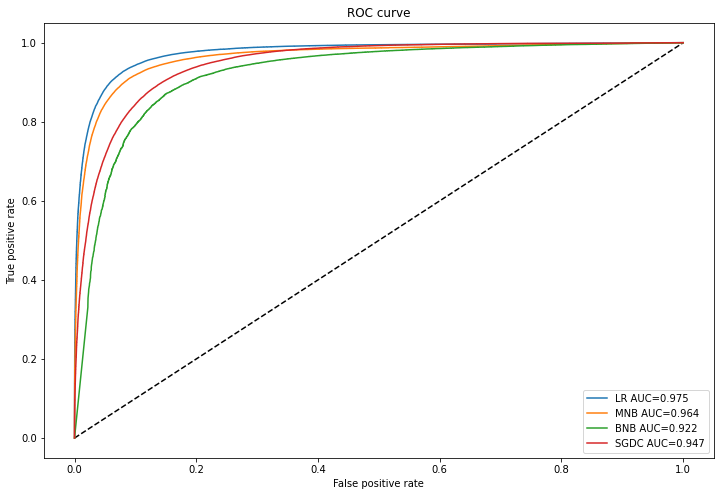

In [57]:
ROC_curve_plots(y_test_smote,y_pred_probs1, y_pred_probs2, y_pred_probs3, y_pred_probs4, 'LR', 'MNB','BNB', 'SGDC')

Inference: Here we can clearly observe that AUC value is highest for Logistic Classifier